# Libraries

In [ ]:
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datetime import datetime
import pyspark
from pyspark import SparkContext
from pyspark.sql import DataFrame
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, udf, when
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler, OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive/
# !mkdir -p 10714
# %cd /content/drive/MyDrive/10714
# !git clone https://github.com/dlsys10714/hw3.git
# %cd /content/drive/MyDrive/10714/hw3

Mounted at /content/drive


In [ ]:

# Creating spark context
sc = SparkContext()
# Create a spark session
spark = SparkSession(sc)

In [ ]:
# ! kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


# Data

In [ ]:
oct_df_path="/content/drive/MyDrive/projects/cie427_big_data/2019-Oct.csv"
nov_df_path="/content/drive/MyDrive/projects/cie427_big_data/2019-Nov.csv"
oct_df_million_path="/content/drive/MyDrive/projects/cie427_big_data/oct_df_million.csv"

In [ ]:
df = pd.read_csv(oct_df_path,nrows=1000000)


In [ ]:
# df.to_csv("oct_df_million.csv",index=False)

In [ ]:
df.head(10)

event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   
5  2019-10-01 00:00:05 UTC       view     1480613  2053013561092866779   
6  2019-10-01 00:00:08 UTC       view    17300353  2053013553853497655   
7  2019-10-01 00:00:08 UTC       view    31500053  2053013558031024687   
8  2019-10-01 00:00:10 UTC       view    28719074  2053013565480109009   
9  2019-10-01 00:00:11 UTC       view     1004545  2053013555631882655   

                         category_code     brand    price    user_id  \
0                                  NaN  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa       NaN   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   
5                    computers.desktop    pulser   908.62  512742880   
6                                  NaN     creed   380.96  555447699   
7                                  NaN  luminarc    41.16  550978835   
8                   apparel.shoes.keds     baden   102.71  520571932   
9               electronics.smartphone    huawei   566.01  537918940   

                           user_session  
0  72d76fde-8bb3-4e00-8c23-a032dfed738c  
1  9333dfbd-b87a-4708-9857-6336556b0fcc  
2  566511c2-e2e3-422b-b695-cf8e6e792ca8  
3  7c90fc70-0e80-4590-96f3-13c02c18c713  
4  c6bd7419-2748-4c56-95b4-8cec9ff8b80d  
5  0d0d91c2-c9c2-4e81-90a5-86594dec0db9  
6  4fe811e9-91de-46da-90c3-bbd87ed3a65d  
7  6280d577-25c8-4147-99a7-abc6048498d6  
8  ac1cd4e5-a3ce-4224-a2d7-ff660a105880  
9  406c46ed-90a4-4787-a43b-59a410c1a5fb

In [ ]:
df.shape

(1000000, 9)

In [ ]:
# df_m = pd.read_csv(oct_df_path, nrows=1000000)
#df_m.to_csv('/content/drive/MyDrive/projects/cie427_big_data/f_one_m.csv')

# Data preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   event_time     1000000 non-null  object 
 1   event_type     1000000 non-null  object 
 2   product_id     1000000 non-null  int64  
 3   category_id    1000000 non-null  int64  
 4   category_code  681869 non-null   object 
 5   brand          852440 non-null   object 
 6   price          1000000 non-null  float64
 7   user_id        1000000 non-null  int64  
 8   user_session   1000000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 68.7+ MB


In [ ]:
df.describe()

product_id   category_id           price       user_id
count  1.000000e+06  1.000000e+06  1000000.000000  1.000000e+06
mean   1.034799e+07  2.056348e+18      295.982471  5.312763e+08
std    1.123827e+07  1.579788e+16      368.216516  1.667333e+07
min    1.001588e+06  2.053014e+18        0.000000  2.449511e+08
25%    1.005115e+06  2.053014e+18       64.320000  5.156507e+08
50%    5.100397e+06  2.053014e+18      161.930000  5.271290e+08
75%    1.640026e+07  2.053014e+18      360.370000  5.480380e+08
max    5.390002e+07  2.175420e+18     2574.070000  5.557175e+08

In [ ]:
df=df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628225 entries, 1 to 999999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     628225 non-null  object 
 1   event_type     628225 non-null  object 
 2   product_id     628225 non-null  int64  
 3   category_id    628225 non-null  int64  
 4   category_code  628225 non-null  object 
 5   brand          628225 non-null  object 
 6   price          628225 non-null  float64
 7   user_id        628225 non-null  int64  
 8   user_session   628225 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 47.9+ MB


In [ ]:
df.where(df['category_code']=='electronics.smartphone')  
#df['electronics.smartphone']

event_time event_type  product_id   category_id  \
1                           NaN        NaN         NaN           NaN   
3                           NaN        NaN         NaN           NaN   
4       2019-10-01 00:00:04 UTC       view   1004237.0  2.053014e+18   
5                           NaN        NaN         NaN           NaN   
8                           NaN        NaN         NaN           NaN   
...                         ...        ...         ...           ...   
999993                      NaN        NaN         NaN           NaN   
999995  2019-10-01 16:56:07 UTC       view   1005115.0  2.053014e+18   
999997                      NaN        NaN         NaN           NaN   
999998  2019-10-01 16:56:07 UTC       view   1004873.0  2.053014e+18   
999999                      NaN        NaN         NaN           NaN   

                 category_code    brand    price      user_id  \
1                          NaN      NaN      NaN          NaN   
3                          NaN      NaN      NaN          NaN   
4       electronics.smartphone    apple  1081.98  535871217.0   
5                          NaN      NaN      NaN          NaN   
8                          NaN      NaN      NaN          NaN   
...                        ...      ...      ...          ...   
999993                     NaN      NaN      NaN          NaN   
999995  electronics.smartphone    apple   975.56  555714787.0   
999997                     NaN      NaN      NaN          NaN   
999998  electronics.smartphone  samsung   388.42  532714334.0   
999999                     NaN      NaN      NaN          NaN   

                                user_session  
1                                        NaN  
3                                        NaN  
4       c6bd7419-2748-4c56-95b4-8cec9ff8b80d  
5                                        NaN  
8                                        NaN  
...                                      ...  
999993                                   NaN  
999995  cdbcf82e-be79-4068-a74b-e8dd93a4c581  
999997                                   NaN  
999998  33e86088-8617-41c1-8e7e-2b95b033a6af  
999999                                   NaN  

[628225 rows x 9 columns]

In [ ]:
# dff['event_type'].values_count
# print(pd.unique(dff['event_type']))
for c in df.select_dtypes(exclude='number').columns:
  # print("col:",c," unique",pd.unique(dff[c]))
    print(len(pd.unique(df[c])),c,pd.unique(df[c]))
    print("-----------------------------------------------------------------------")

53305 event_time ['2019-10-01 00:00:00 UTC' '2019-10-01 00:00:01 UTC'
 '2019-10-01 00:00:04 UTC' ... '2019-10-01 16:56:05 UTC'
 '2019-10-01 16:56:06 UTC' '2019-10-01 16:56:07 UTC']
-----------------------------------------------------------------------
3 event_type ['view' 'purchase' 'cart']
-----------------------------------------------------------------------
122 category_code ['appliances.environment.water_heater' 'computers.notebook'
 'electronics.smartphone' 'computers.desktop' 'apparel.shoes.keds'
 'appliances.kitchen.microwave' 'furniture.bedroom.bed'
 'electronics.video.tv' 'appliances.kitchen.mixer'
 'electronics.audio.headphone' 'appliances.environment.air_heater'
 'apparel.shoes' 'appliances.environment.vacuum'
 'appliances.kitchen.refrigerators' 'appliances.kitchen.washer'
 'computers.peripherals.monitor' 'construction.tools.pump'
 'electronics.clocks' 'apparel.shoes.slipons'
 'appliances.kitchen.meat_grinder' 'computers.components.videocards'
 'construction.tools.drill' '

In [ ]:
dff=df.copy(deep=True)

In [ ]:
dff['is_purchased'] =dff['event_type']== "purchase"

In [ ]:
dff['is_purchased']

1         False
3         False
4         False
5         False
8         False
          ...  
999993    False
999995    False
999997    False
999998    False
999999    False
Name: is_purchased, Length: 628225, dtype: bool

In [ ]:
dff['is_purchased'].replace([True, False],[ 1,0], inplace=True)


In [ ]:
# dff = dff.withColumn("is_purchased", (df_targets["event_type"]=="purchase").cast("int")) # add boolean based on event type, 1 for purchase, 0 otherwise


In [ ]:
# dfff=dff['category_id'],dff['is_purchased']

In [ ]:
# dfff=pd.DataFrame(dff['category_id'],dff['is_purchased'])

In [ ]:
dfff = dff[['category_id','price', 'is_purchased']].copy()

In [ ]:
dfff['price']

1           33.20
3          251.74
4         1081.98
5          908.62
8          102.71
           ...   
999993     352.39
999995     975.56
999997     849.42
999998     388.42
999999      86.23
Name: price, Length: 628225, dtype: float64

# EDA

In [ ]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

# SQL Queries Analysis

## Purchase Event Type

In [ ]:
df_market=df.copy(deep=True)

In [ ]:
df_event_type_purchase = df_market.select('*').where(df_market.event_type == 'purchase')
df_event_type_purchase.show()

+----------+-------------------+--------------------+--------+-------+
|event_type|        category_id|       category_code|   brand|  price|
+----------+-------------------+--------------------+--------+-------+
|  purchase|2053013555631882655|electronics.smart...| samsung|1286.75|
|  purchase|2053013555631882655|electronics.smart...|   apple| 464.13|
|  purchase|2053013555631882655|electronics.smart...|   apple| 464.08|
|  purchase|2053013555631882655|electronics.smart...|   apple| 514.76|
|  purchase|2053013552955916539|computers.periphe...|   epson| 116.73|
|  purchase|2053013555631882655|electronics.smart...| samsung| 254.76|
|  purchase|2053013555631882655|electronics.smart...|   apple| 738.61|
|  purchase|2053013555631882655|electronics.smart...| samsung| 230.89|
|  purchase|2053013555631882655|electronics.smart...|   apple| 975.57|
|  purchase|2053013553945772349|electronics.audio...|   hertz|  40.88|
|  purchase|2053013555631882655|electronics.smart...|   apple| 738.61|
|  pur

### Dataframe for visualisation

In [ ]:
df_event_type_purchase_pandas = df_event_type_purchase.toPandas()

In [ ]:
df_event_type_purchase_pandas.head()

event_type          category_id                  category_code    brand  \
0   purchase  2053013555631882655         electronics.smartphone  samsung   
1   purchase  2053013555631882655         electronics.smartphone    apple   
2   purchase  2053013555631882655         electronics.smartphone    apple   
3   purchase  2053013555631882655         electronics.smartphone    apple   
4   purchase  2053013552955916539  computers.peripherals.printer    epson   

     price  
0  1286.75  
1   464.13  
2   464.08  
3   514.76  
4   116.73

In [ ]:
df_event_type_purchase_pandas = df_event_type_purchase_pandas.drop(['category_id', 'event_type'], axis=1)
df_event_type_purchase_pandas = df_event_type_purchase_pandas.astype({'price':'float'})
df_event_type_purchase_pandas.to_csv('df_event_type_purchase_pandas.csv')
df_event_type_purchase_pandas.head()

category_code    brand    price
0         electronics.smartphone  samsung  1286.75
1         electronics.smartphone    apple   464.13
2         electronics.smartphone    apple   464.08
3         electronics.smartphone    apple   514.76
4  computers.peripherals.printer    epson   116.73

### Visualize

#### DataPrep

DataPrep Report
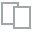
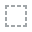
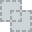
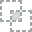
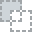
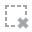
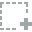
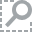
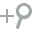
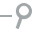
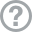
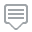
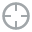
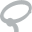
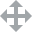
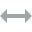
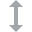
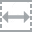
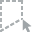
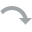
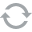
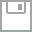
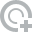
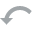
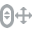
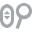
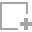
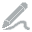
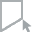
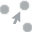
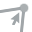
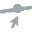

In [ ]:
create_report(df_event_type_purchase_pandas)

## Cart Event Type

In [ ]:
df_event_type_cart = df_market.select('*').where(df_market.event_type == 'cart')
df_event_type_cart.show()

+----------+-------------------+--------------------+---------+-------+
|event_type|        category_id|       category_code|    brand|  price|
+----------+-------------------+--------------------+---------+-------+
|      cart|2053013555631882655|electronics.smart...|   huawei| 243.25|
|      cart|2053013555631882655|electronics.smart...|   xiaomi| 185.71|
|      cart|2053013555631882655|electronics.smart...|    apple|1052.79|
|      cart|2053013555631882655|electronics.smart...|   xiaomi| 185.71|
|      cart|2053013555631882655|electronics.smart...|  samsung| 286.35|
|      cart|2053013555631882655|electronics.smart...|  samsung| 254.76|
|      cart|2053013555631882655|electronics.smart...|  samsung| 174.75|
|      cart|2053013555631882655|electronics.smart...|     oppo| 179.36|
|      cart|2053013555631882655|electronics.smart...|  samsung| 286.86|
|      cart|2053013554658804075|electronics.audio...|    apple| 188.73|
|      cart|2053013555631882655|electronics.smart...|  samsung| 

### Dataframe for visualisation

In [ ]:
df_event_type_cart_pandas = df_event_type_cart.toPandas()

In [ ]:
df_event_type_cart_pandas.head()

event_type          category_id           category_code    brand    price
0       cart  2053013555631882655  electronics.smartphone   huawei   243.25
1       cart  2053013555631882655  electronics.smartphone   xiaomi   185.71
2       cart  2053013555631882655  electronics.smartphone    apple  1052.79
3       cart  2053013555631882655  electronics.smartphone   xiaomi   185.71
4       cart  2053013555631882655  electronics.smartphone  samsung   286.35

In [ ]:
df_event_type_cart_pandas = df_event_type_cart_pandas.drop(['category_id', 'event_type'], axis=1)

In [ ]:
df_event_type_cart_pandas = df_event_type_cart_pandas.astype({'price':'float'})

In [ ]:
df_event_type_cart_pandas.to_csv('df_event_type_cart_pandas.csv')

In [ ]:
df_event_type_cart_pandas.head()

category_code    brand    price
0  electronics.smartphone   huawei   243.25
1  electronics.smartphone   xiaomi   185.71
2  electronics.smartphone    apple  1052.79
3  electronics.smartphone   xiaomi   185.71
4  electronics.smartphone  samsung   286.35

### Visualize

#### DataPrep

DataPrep Report
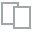
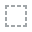
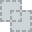
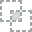
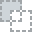
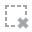
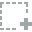
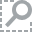
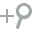
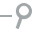
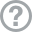
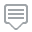
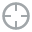
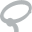
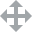
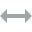
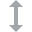
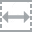
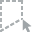
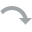
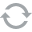
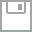
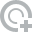
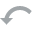
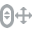
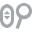
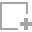
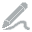
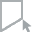
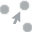
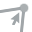
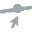

In [ ]:
create_report(df_event_type_cart_pandas)

## View Event Type

In [ ]:
df_event_type_view = df_market.select('*').where(df_market.event_type == 'view')

In [ ]:
df_event_type_view.show()

+----------+-------------------+--------------------+----------------+-------+
|event_type|        category_id|       category_code|           brand|  price|
+----------+-------------------+--------------------+----------------+-------+
|      view|2053013563810775923|appliances.kitche...|hotpoint-ariston| 275.37|
|      view|2053013554658804075|electronics.audio...|             jbl|  33.21|
|      view|2053013563810775923|appliances.kitche...|         samsung| 463.15|
|      view|2053013555262783879|appliances.kitche...|           vitek|  23.14|
|      view|2053013552351936731|appliances.enviro...|         almacom| 276.33|
|      view|2053013554658804075|electronics.audio...|           apple|  25.45|
|      view|2053013555631882655|electronics.smart...|         samsung| 746.48|
|      view|2053013555631882655|electronics.smart...|         samsung| 154.42|
|      view|2053013555631882655|electronics.smart...|           apple| 952.15|
|      view|2053013561579406073|  electronics.clocks

### Dataframe for visualisation

In [ ]:
df_event_type_view_pandas = df_event_type_view.toPandas()
df_event_type_view_pandas.head()

event_type          category_id                           category_code  \
0       view  2053013563810775923               appliances.kitchen.washer   
1       view  2053013554658804075             electronics.audio.headphone   
2       view  2053013563810775923               appliances.kitchen.washer   
3       view  2053013555262783879              appliances.kitchen.blender   
4       view  2053013552351936731  appliances.environment.air_conditioner   

              brand   price  
0  hotpoint-ariston  275.37  
1               jbl   33.21  
2           samsung  463.15  
3             vitek   23.14  
4           almacom  276.33

In [ ]:
df_event_type_view_pandas = df_event_type_view_pandas.drop(['category_id', 'event_type'], axis=1)
df_event_type_view_pandas = df_event_type_view_pandas.astype({'price':'float'})
df_event_type_view_pandas.to_csv('df_event_type_view_pandas.csv')
df_event_type_view_pandas.head()

category_code             brand   price
0               appliances.kitchen.washer  hotpoint-ariston  275.37
1             electronics.audio.headphone               jbl   33.21
2               appliances.kitchen.washer           samsung  463.15
3              appliances.kitchen.blender             vitek   23.14
4  appliances.environment.air_conditioner           almacom  276.33

### Visualize

#### DataPrep

DataPrep Report
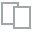
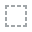
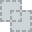
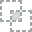
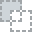
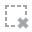
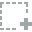
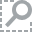
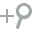
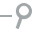
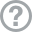
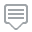
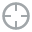
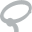
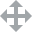
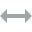
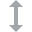
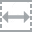
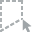
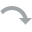
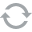
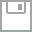
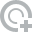
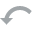
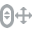
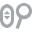
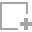
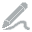
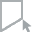
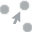
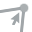
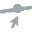

In [ ]:
create_report(df_event_type_view_pandas)

# Analyzing the whole dataset

In [ ]:
df_market=df_market.drop(*['category_id'])

In [ ]:
df_market = df_market.toPandas()

In [ ]:
df_market = df_market.astype({'price':'float'})

In [ ]:
df_market.to_csv('df_market.csv')

In [ ]:
df_market.head()

event_type                           category_code             brand   price
0       view               appliances.kitchen.washer  hotpoint-ariston  275.37
1       view             electronics.audio.headphone               jbl   33.21
2       view               appliances.kitchen.washer           samsung  463.15
3       view              appliances.kitchen.blender             vitek   23.14
4       view  appliances.environment.air_conditioner           almacom  276.33

##  Visualize

#### DataPrep

DataPrep Report
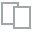
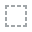
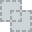
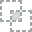
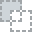
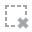
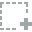
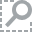
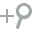
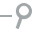
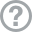
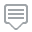
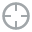
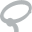
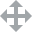
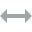
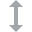
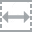
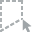
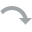
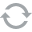
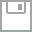
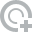
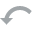
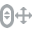
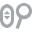
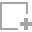
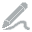
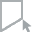
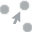
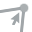
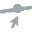

In [ ]:
create_report(df_market)

#Customer Behaviour Analysis (CBA)

In [ ]:
df_market = df
df_market = df_market.dropDuplicates()
#df_market=df_market.drop(*['event_time','product_id', 'user_id', 'user_session'])

In [ ]:
from pyspark.sql.functions import sum
df_market.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_market.columns)).show()

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|         0|         0|         0|          0|       318053|147550|    0|      0|           0|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+



In [ ]:
df_market = df_market.dropna()
df_market.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_market.columns)).show()

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|          0|            0|    0|    0|      0|           0|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



In [ ]:
df_market.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
df_pandas = df_market.select(substring(col("price").cast("float"), 0, 10).alias("avg_price"), substring(col("event_time"), 0, 10).alias("day")).toPandas()


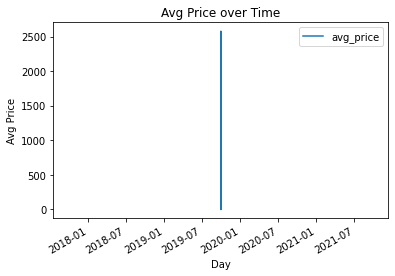

In [ ]:

# convert the column to numeric data type
df_pandas['avg_price'] = pd.to_numeric(df_pandas['avg_price'], errors='coerce')
df_pandas['day'] = pd.to_datetime(df_pandas['day'])

# Set the 'day' column as the index
df_pandas.set_index('day', inplace=True)

# Plot the data
df_pandas.plot()
plt.xlabel("Day")
plt.ylabel("Avg Price")
plt.title("Avg Price over Time")
plt.show()

In [ ]:
df_2 = df_market.select(col("price").cast("float").alias("avg_price")).toPandas()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627805 entries, 0 to 627804
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   avg_price  627805 non-null  float32
dtypes: float32(1)
memory usage: 2.4 MB


In [ ]:
from pyspark.sql.functions import floor
from pyspark.sql.functions import col

#col("price").cast("float").alias("avg_price")

df_samsung_purchase = df_market.select(
    #col("event_time").alias("time"),
    col("category_code").alias("code"), 
    #col("event_type").alias("type"),
    col("brand").alias("brand")
).where(
    #(col("category_code") == 'electronics.smartphone') & 
    (col("event_type") == 'purchase')#&  (col("brand") == 'samsung')
).toPandas()

# & (col("brand") == 'samsung')
print(df_samsung_purchase)


                                code    brand
0             electronics.smartphone  samsung
1             electronics.smartphone    apple
2             electronics.smartphone    apple
3             electronics.smartphone    apple
4      computers.peripherals.printer    epson
...                              ...      ...
12824   construction.tools.generator  polaris
12825         electronics.smartphone  samsung
12826                  apparel.shoes  respect
12827         electronics.smartphone     oppo
12828         electronics.smartphone  samsung

[12829 rows x 2 columns]


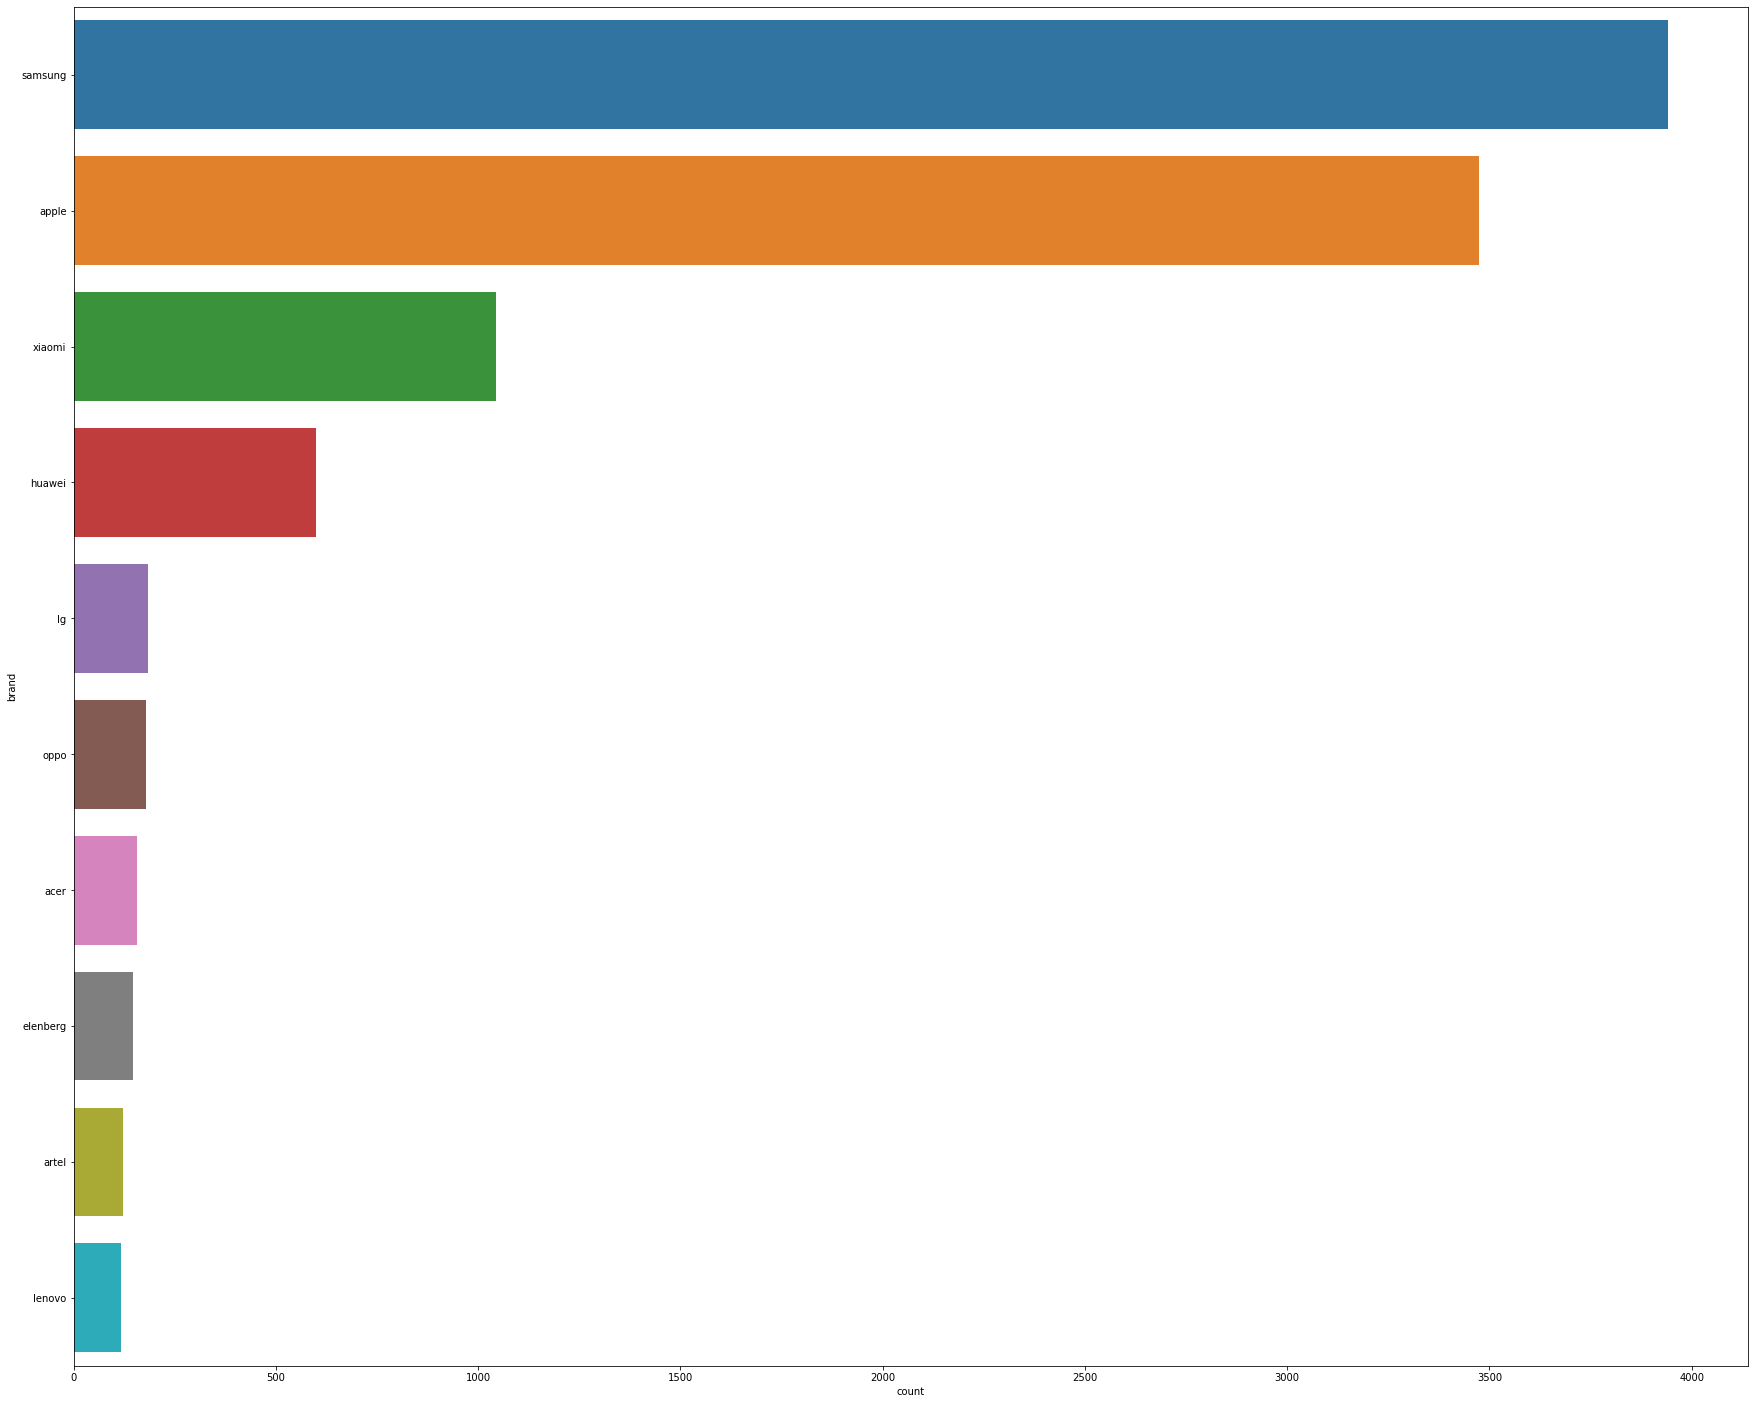

In [ ]:
import matplotlib.pyplot as plt

# Count the values in the two columns
df_plot = df_samsung_purchase.groupby(['code','brand']).size().reset_index(name='counts')


import seaborn as sns
top_10_brands = df_samsung_purchase['brand'].value_counts().nlargest(10)
plt.figure(figsize=(30,25))
sns.countplot(y='brand', data=df_samsung_purchase, order=top_10_brands.index)

In [ ]:
df_samsung_purchase['code'].unique()

array(['electronics.smartphone', 'computers.peripherals.printer',
       'electronics.audio.subwoofer', 'electronics.clocks',
       'computers.components.memory', 'appliances.kitchen.mixer',
       'appliances.personal.hair_cutter', 'electronics.video.tv',
       'computers.notebook', 'appliances.environment.water_heater',
       'computers.peripherals.monitor', 'computers.desktop',
       'appliances.kitchen.hood', 'construction.tools.painting',
       'accessories.bag', 'appliances.kitchen.coffee_machine',
       'electronics.audio.headphone', 'kids.skates',
       'appliances.environment.air_heater', 'apparel.shoes.keds',
       'electronics.tablet', 'appliances.kitchen.toster',
       'electronics.telephone', 'appliances.environment.vacuum',
       'appliances.kitchen.kettle', 'electronics.audio.acoustic',
       'auto.accessories.alarm', 'appliances.kitchen.washer',
       'construction.tools.generator', 'auto.accessories.player',
       'appliances.kitchen.microwave', 'appliance

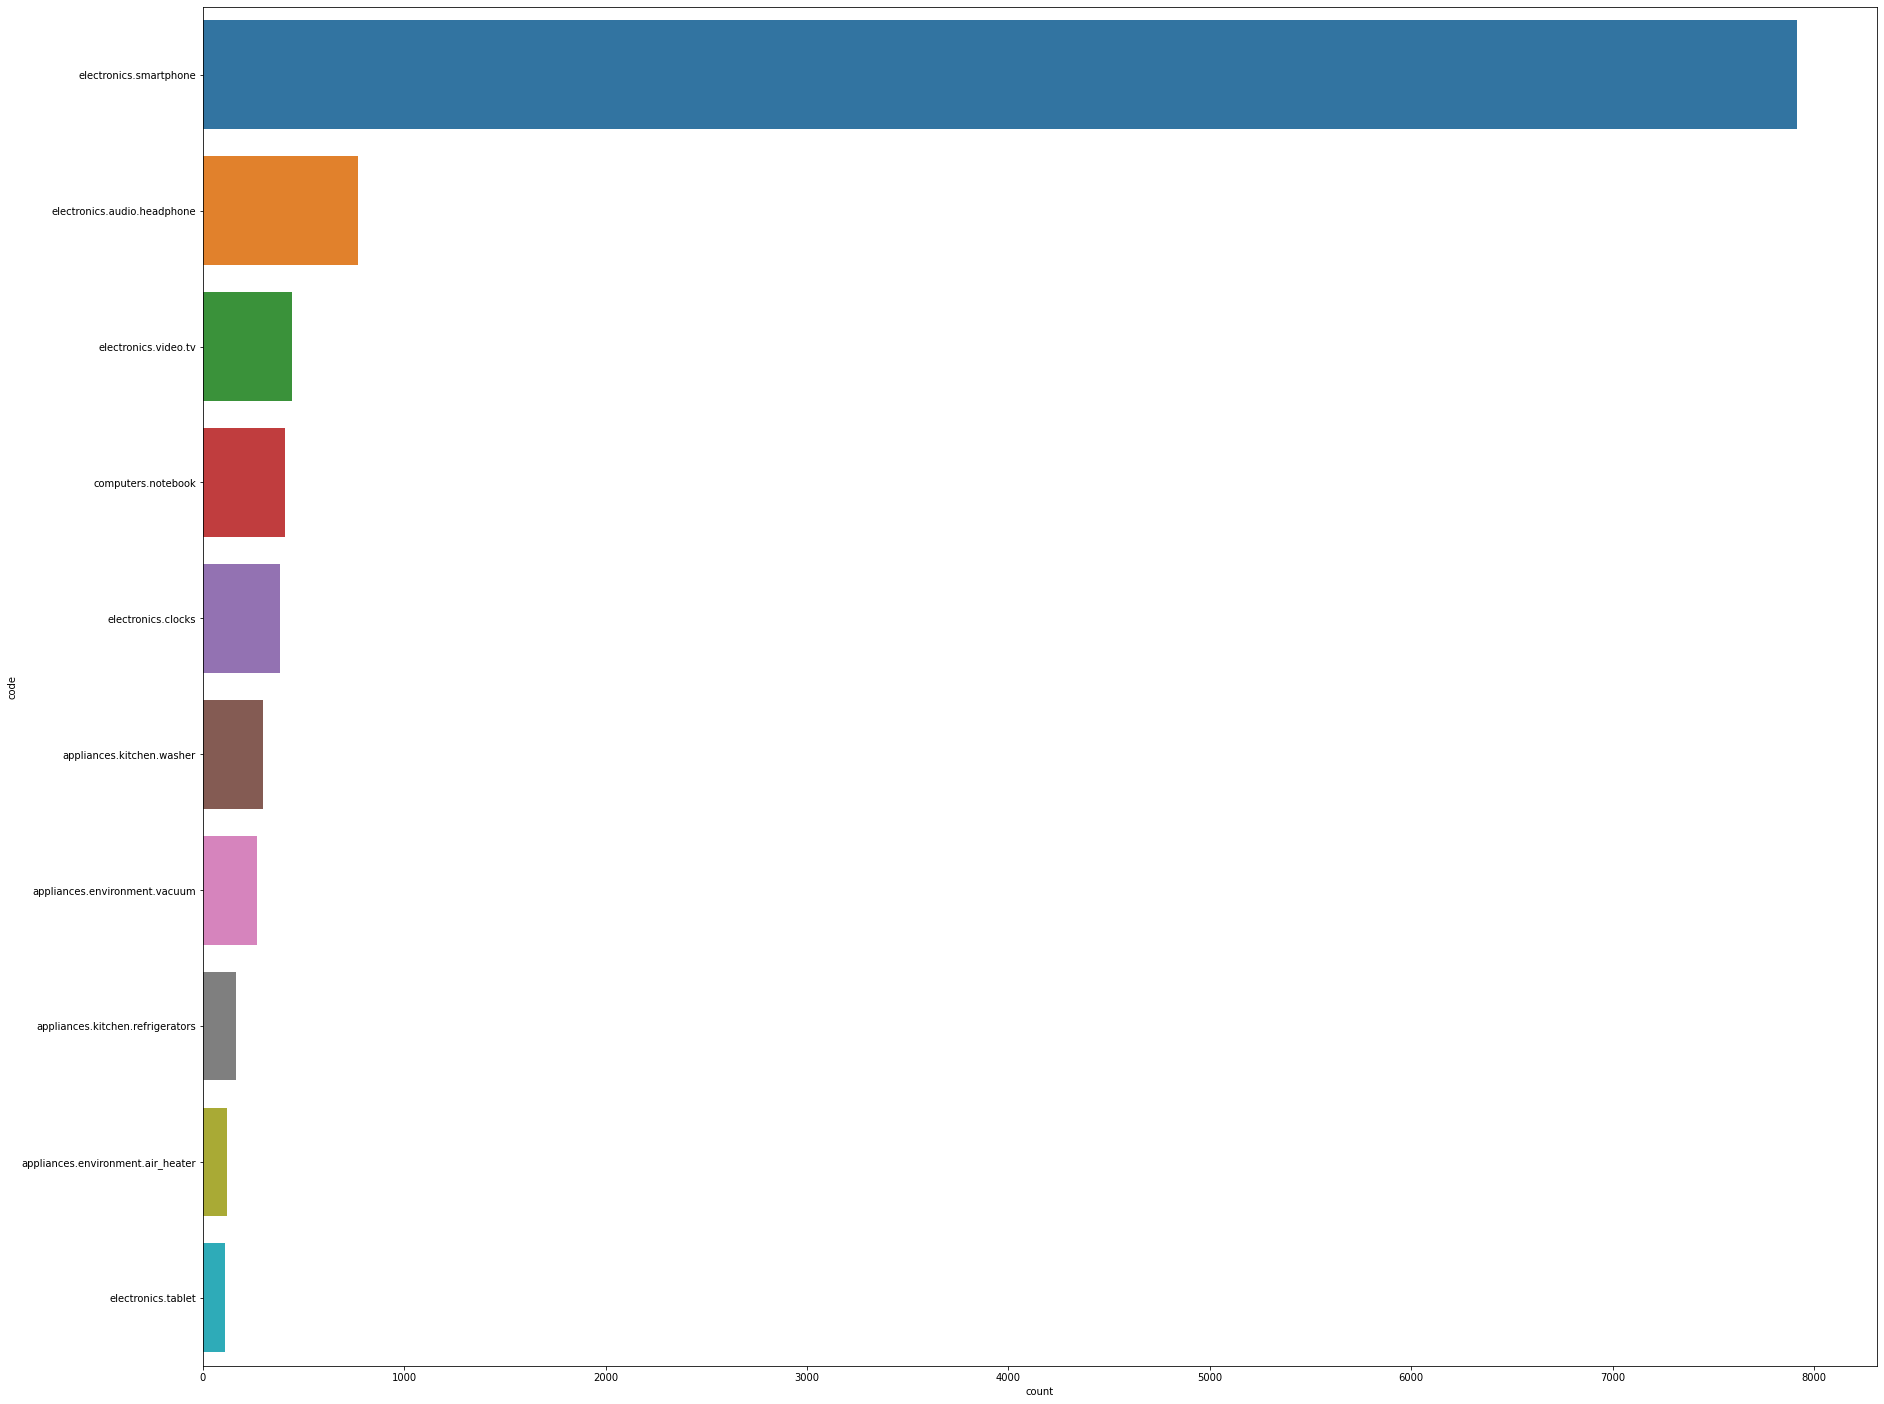

In [ ]:

top_10_codes = df_samsung_purchase['code'].value_counts().nlargest(10)
plt.figure(figsize=(30,25))
sns.countplot(y='code', data=df_samsung_purchase, order=top_10_codes.index)

In [ ]:
df_purchase_count = df_samsung_purchase.groupby("code").size().reset_index(name='counts')
df_purchase_count = df_purchase_count.sort_values(by='counts', ascending=False)
df_purchase_count

code  counts
73           electronics.smartphone    7916
67      electronics.audio.headphone     771
77             electronics.video.tv     443
51               computers.notebook     407
72               electronics.clocks     383
..                              ...     ...
64          country_yard.cultivator       1
1              accessories.umbrella       1
29  appliances.kitchen.steam_cooker       1
38      auto.accessories.parktronic       1
65          country_yard.lawn_mower       1

[98 rows x 2 columns]

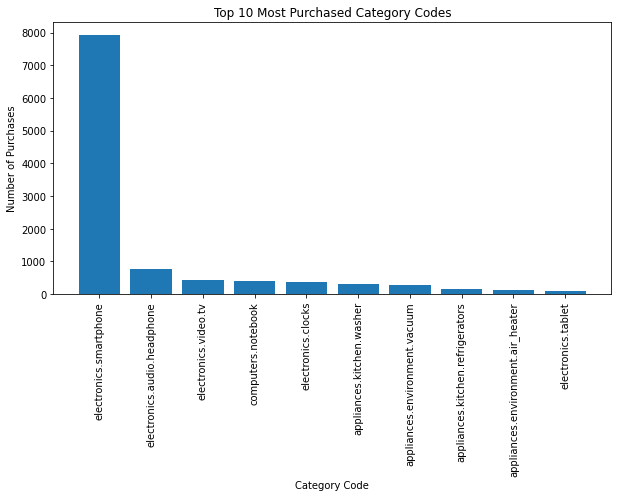

In [ ]:
df_purchase_count_top10 = df_purchase_count.head(10)

plt.figure(figsize=(10,5))
plt.bar(df_purchase_count_top10['code'], df_purchase_count_top10['counts'])
plt.xlabel('Category Code')
plt.ylabel('Number of Purchases')
plt.title('Top 10 Most Purchased Category Codes')
plt.xticks(rotation=90)
plt.show()


# machine learning model to predict Customer Behavior

In [ ]:
df = spark.read.option("header",True).csv(oct_df_million_path)
# df = spark.read.option("header",True).csv(oct_df_path)

In [ ]:
df_modified=df.withColumn("category_code",when(col("category_code")=="construction.tools.light","electronics.smartphone").otherwise(col("category_code")))

df_final = df_modified.filter(df_modified["event_type"].isin('cart','purchase')).drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session']) # select only cart and purchase events

df_final = df_final.dropna(how='any')

df_final = df_final.withColumn("is_purchased", (df_final["event_type"]=="purchase").cast("int")) # add boolean column based on event type, 1 for purchase, 0 otherwise

df_final = df_final.withColumn("price", df_final["price"].cast("float"))


In [ ]:
brand_indexer = StringIndexer(inputCol="brand", outputCol="brand_index").fit(df_final)

train, test = df_final.randomSplit([0.9, 0.1], seed=54321)

vectorAssembler = VectorAssembler(outputCol="features")


# set training parameters
# Creating a vector assembler for price and brand_index columns
vectorAssembler.setInputCols(["price","brand_index"])

GBTC = GBTClassifier(labelCol="is_purchased", featuresCol="features", maxIter=20, maxBins = 4000)
indexers = [ brand_indexer,  vectorAssembler, GBTC]
pipeline = Pipeline(stages=indexers)


In [ ]:
model = pipeline.fit(train)

In [ ]:
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="is_purchased", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
evaluator.setMetricName("weightedPrecision")

precision = evaluator.evaluate(predictions)
evaluator.setMetricName("weightedRecall")

recall = evaluator.evaluate(predictions)

In [ ]:
print('Accuracy= {}\nweighted Precision= {}\nweighted Recall= {}'.format(accuracy,precision,recall))

Accuracy= 0.5668374476013042
weighted Precision= 0.5504533831739045
weighted Recall= 0.5668374476013042


# NAMs

In [ ]:
dfff = dff[['category_id','price', 'is_purchased']].copy()

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(dfff[['category_id','price']], dfff[['is_purchased']], test_size=0.1, random_state=42)

In [ ]:
# !pip install git+https://github.com/lemeln/nam

In [ ]:
# importing the NAM model
pip install git+https://github.com/Abdullah-Eisa/nam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Abdullah-Eisa/nam to /tmp/pip-req-build-ux4ektuf
  Running command git clone --filter=blob:none --quiet https://github.com/Abdullah-Eisa/nam /tmp/pip-req-build-ux4ektuf
  Resolved https://github.com/Abdullah-Eisa/nam to commit 65e4fffdfcb495ef5399a07bd27da905976ffcdf
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 8.0 MB/s eta 0:00:00
  Created wheel for nam-interpret: filename=nam_interpret-0.0.0-py3-none-any.whl size=19472 sha256=bbf8168ee85add986363d586b9fadabbcca8fbeb4f03813db9961cde0a829a1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-yrmkx7sj/wheels/62/5b/4b/66b7aa326f2e3c9e9764bd89a8c84547e894a138a74b6dcd9b
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  not

In [ ]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

In [ ]:
random_state = 2016


In [ ]:
len(X_train),len(y_train)

(565402, 565402)

In [ ]:
# defining the NAM model
model = NAMClassifier(
            num_epochs=5,
            num_learners=5,
            metric='auroc',
            early_stop_mode='max',
            monitor_loss=False,
            random_state=random_state
        )
%prun model.fit(X_train, y_train)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
y_pred_prop = model.predict_proba(X_test)
sk_metrics.roc_auc_score(y_test, y_pred_prop)

0.5